* LSTM by Chainer
* ver. L.LSTM

In [2]:
import datetime
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import chainer
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions

In [3]:
# 教師データ
train_data = np.array([np.sin(i*2*np.pi/50) for i in range(50)]*10)
 
# 教師データを変換
train_x, train_y = [], []
for i in range(len(train_data)-1):
    train_x.append(train_data[i])
    train_y.append(train_data[i+1])
train_x = np.array(train_x, dtype=np.float32)
train_y = np.array(train_y, dtype=np.float32)
in_size = 1
out_size = 1
N = len(train_x)

In [8]:
class LSTM(chainer.Chain):
    
    def __init__(self, in_size, hidden_size, out_size): # 入力層のサイズ、隠れ層のサイズ、出力層のサイズ
        
        # クラスの初期化
        super(LSTM, self).__init__(
            xh = L.Linear(in_size, hidden_size),
            hh = L.LSTM(hidden_size, hidden_size),
            hy = L.Linear(hidden_size, out_size)
        )
 
    def __call__(self, x, t=None, train=False): # 入力値、正解の予測値、学習かどうか
        
        # 順伝播の計算を行う関数
        x = chainer.Variable(x)
        if train:
            t = chainer.Variable(t)
            
        h = self.xh(x)
        h = self.hh(h)
        y = self.hy(h)
        
        if train:
            return F.mean_squared_error(y, t)
        else:
            return y.data
 
    def reset(self):
        
        # 勾配の初期化とメモリの初期化
        self.zerograds()
        self.hh.reset_state()

In [9]:
hidden_size = 5

gpu = 0

model = LSTM(in_size=in_size, hidden_size=hidden_size, out_size=out_size)
optimizer = chainer.optimizers.Adam()
optimizer.setup(model)

if gpu >= 0:
    
    chainer.cuda.get_device(gpu).use()
    model.to_gpu(gpu)

In [10]:
# train

epoch_num = 1000
batch_row_size = 100 # 分割した時系列をいくつミニバッチに取り込むか
batch_col_size = 100 # ミニバッチで分割する時系列数

st = datetime.datetime.now()
for epoch in range(epoch_num):

    # ミニバッチ学習
    x, t = [], []
    #  ミニバッチ学習データとして、時系列全体から、batch_col_size分の時系列を抜き出したものを、batch_row_size個用意する
    for i in range(batch_row_size):
        
        index = np.random.randint(0, N-batch_col_size+1) # ランダムな箇所、ただしbatch_col_size分だけ抜き取れる場所から選ぶ
        x.append(train_x[index:index+batch_col_size]) # batch_col_size分の時系列を取り出す
        t.append(train_y[index:index+batch_col_size])
        
    x = np.array(x, dtype=np.float32)
    t = np.array(t, dtype=np.float32)
    
    loss = 0
    total_loss = 0
    model.reset() # 勾配とメモリの初期化
    
    for i in range(batch_col_size): # 各時刻おきにbatch_row_sizeごと読み込んで損失を計算する
        
        x_ = np.array([x[j, i] for j in range(batch_row_size)], dtype=np.float32)[:, np.newaxis] # 時刻iの入力値
        t_ = np.array([t[j, i] for j in range(batch_row_size)], dtype=np.float32)[:, np.newaxis] # 時刻i+1の値（＝正解の予測値）
        
        if gpu >= 0:
            x_ = chainer.cuda.to_gpu(x_)
            t_ = chainer.cuda.to_gpu(t_)
            
        loss += model(x=x_, t=t_, train=True)
        
    loss.backward()
    loss.unchain_backward()
    total_loss += loss.data
    optimizer.update()
    
    if (epoch+1) % 100 == 0:
        
        ed = datetime.datetime.now()
        print("epoch:\t{}\ttotal loss:\t{}\ttime:\t{}".format(epoch+1, total_loss, ed-st))
        st = datetime.datetime.now()

epoch:	100	total loss:	14.285663	time:	0:00:50.370624
epoch:	200	total loss:	2.2237937	time:	0:00:49.982191
epoch:	300	total loss:	1.367862	time:	0:00:50.181997
epoch:	400	total loss:	1.1236044	time:	0:00:50.005335
epoch:	500	total loss:	0.8228644	time:	0:00:50.031545
epoch:	600	total loss:	0.6952496	time:	0:00:49.920654
epoch:	700	total loss:	0.59590715	time:	0:00:50.164323
epoch:	800	total loss:	0.5724077	time:	0:00:50.012408
epoch:	900	total loss:	0.48754695	time:	0:00:50.003733
epoch:	1000	total loss:	0.44639733	time:	0:00:49.980719


In [11]:
model.to_cpu()

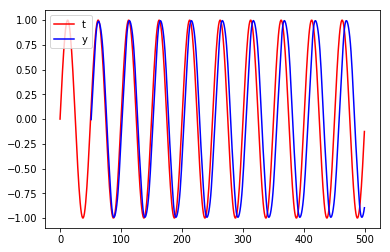

In [12]:
predict = np.empty(0) # 予測時系列
inseq_size = 50
inseq = train_data[:inseq_size] # 予測直前までの時系列

for _ in range(N - inseq_size):
    
    model.reset() # メモリを初期化
    for i in inseq: # モデルに予測直前までの時系列を読み込ませる
        x = np.array([[i]], dtype="float32")
        y = model(x=x, train=False)
    predict = np.append(predict, y) # 最後の予測値を記録
    # モデルに読み込ませる予測直前時系列を予測値で更新する
    inseq = np.delete(inseq, 0)
    inseq = np.append(inseq, y)

plt.plot(range(N+1), train_data, color="red", label="t")
plt.plot(range(inseq_size+1, N+1), predict, color="blue", label="y")
plt.legend(loc="upper left")
plt.show()

In [13]:
!python --version

Python 3.6.3


In [14]:
!pip freeze

absl-py==0.2.0
astor==0.6.2
backcall==0.1.0
bleach==1.5.0
boto==2.49.0
boto3==1.7.73
botocore==1.10.73
bz2file==0.98
certifi==2018.4.16
chainer==4.0.0
chainercv==0.10.0
chardet==3.0.4
cntk-gpu==2.5.1
cupy==4.0.0
cycler==0.10.0
Cython==0.28.2
decorator==4.3.0
dm-sonnet==1.20
docutils==0.14
edward==1.3.5
entrypoints==0.2.3
fastrlock==0.3
filelock==3.0.4
future==0.16.0
gast==0.2.0
gensim==3.5.0
graphviz==0.8.3
grpcio==1.11.0
h5py==2.7.1
html5lib==0.9999999
idna==2.6
ipykernel==4.8.2
ipython==6.3.1
ipython-genutils==0.2.0
ipywidgets==7.2.1
jedi==0.12.0
Jinja2==2.10
jmespath==0.9.3
jsonschema==2.6.0
jupyter==1.0.0
jupyter-client==5.2.3
jupyter-console==5.2.0
jupyter-core==4.4.0
Keras==2.1.6
kiwisolver==1.0.1
Lasagne==0.2.dev1
leveldb==0.194
Mako==1.0.7
Markdown==2.6.11
MarkupSafe==1.0
matplotlib==2.2.2
mecab-python3==0.7
mistune==0.8.3
mxnet-cu90==1.1.0.post0
nbconvert==5.3.1
nbformat==4.4.0
networkx==2.1
nose==1.3.7
notebook==5.4.1
numpy==1.14.3
pandas==0.22.0
pandocfilters==1.4.2
parso==0

In [15]:
!cat /proc/driver/nvidia/version

NVRM version: NVIDIA UNIX x86_64 Kernel Module  384.111  Tue Dec 19 23:51:45 PST 2017
GCC version:  gcc version 5.4.0 20160609 (Ubuntu 5.4.0-6ubuntu1~16.04.10) 


In [16]:
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2017 NVIDIA Corporation
Built on Fri_Sep__1_21:08:03_CDT_2017
Cuda compilation tools, release 9.0, V9.0.176
